# analysis

## ToDo

- ~~Importing more than one json file~~
- ~~How to group by subjects models and movement~~
- ~~Model specific confusion rat~~
- How to manage or represent all this data
- ...

## data structure

Grouping
- subjects
- models
    - type overall
    - individual configuration
- movement
    - type overall
    - with(out) contact

## loading data
json file needs to be normalized

In [13]:
import numpy as np
import pandas as pd
import json, os
import matplotlib.pyplot as plt
import seaborn as sns

In [14]:
def parse_modelname(x='model(dmp)-dataset(return-bottle-hold)-npsi(90)-hold(1)'):
    x = x.split('-dataset(')
    typ = x[1].split(')',1)
    typ = typ[1]
    x = x[0].split('model(')
    x = x[1][:-1]
    return x + typ

In [15]:
path_to_json = '/users/hieu/git/turing_test_walking/data'

json_files = [pos_json for pos_json in os.listdir(path_to_json) if pos_json.endswith('.json')]
json_files.pop()
first_file = json_files.pop()
with open(first_file,'r') as f:
    one = json.loads(f.read())
data = pd.json_normalize(one)

#workaround for concatenating unnormalized data
for file in json_files:
    with open(file,'r') as f:
        one = json.loads(f.read())
    load = pd.json_normalize(one)
    data = pd.concat([data,load])

  ## parsing

In [16]:
# filtering test parts and creating new index
df = data[data['test_part'] == 'response']#.reset_index()
df = df.fillna(value='99')
df = df[df['key_press'] != '99'].reset_index()

# this line below for filtering attention checks overall out -> uncomment for using it
# df = data[(data['test_part'] == 'response') & (data['.att_check'] == False)].reset_index()

# must be integers for comparing
df['key_press'] = df['key_press'].astype(int)
df['test_stimulus.position'] = df['test_stimulus.position'].astype(int)

# renaming columns
df = df.rename(columns={"test_stimulus.left": "left",
                        "test_stimulus.right": "right",
                        "test_stimulus.att_check": "att_check",
                        "test_stimulus.position": "position",
                        "key_press":"pressed"})

In [17]:
df = df[['sona','subject','rt','att_check','pressed','position','left','right']]

In [18]:
# without copy() there is an error when replacing strings
d = df.copy()

In [19]:
# removing unnecessary strings
d['left'] = d['left'].str.replace('bvh/vr_prediction_models/','')
d['left'] = d['left'].str.replace('bvh/','')
d['left'] = d['left'].str.replace('/final-lines.txt','')
d['left'] = d['left'].str.replace('-lines.txt','')
d['right'] = d['right'].str.replace('bvh/vr_prediction_models/','')
d['right'] = d['right'].str.replace('bvh/','')
d['right'] = d['right'].str.replace('/final-lines.txt','')
d['right'] = d['right'].str.replace('-lines.txt','')

In [20]:
d['pressed']

0       74
1       74
2       74
3       74
4       70
        ..
1528    74
1529    74
1530    70
1531    70
1532    74
Name: pressed, Length: 1533, dtype: int64

In [21]:
# recode keypress
num = 0
arr = []
for i in d['pressed']:
    if i == 70:
        arr.append(0)
        
    elif i == 74:
        arr.append(1)
d['pressed'] = arr

In [22]:
d['position']

0       1
1       1
2       0
3       0
4       0
       ..
1528    1
1529    1
1530    0
1531    0
1532    1
Name: position, Length: 1533, dtype: int64

In [23]:
# adding movement column for better grouping
num = 0
arr = []

for i in d['position']:
    if i == 1:
        arr.append(d['right'][num])
    else:
        arr.append(d['left'][num])
    num += 1

movement = []
for i in arr:
    x = i.split('-')
    movement.append('-'.join(x[:-1]))
d['movement'] = movement

In [24]:
# adding model column for easier grouping by
num = 0
arr = []
for i in d['position']:
    if i == 1:
        arr.append(d['left'][num])
    else:
        arr.append(d['right'][num])
    num += 1
d['model_set'] = arr

In [25]:
d

,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set
0,6982,89tjwumsgd28j96,300.860,False,1,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training1,pass-bottle,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...
1,6982,89tjwumsgd28j96,628.465,False,1,1,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold-training3,return-bottle-hold,model(vcgpdm)-dataset(return-bottle-hold)-mode...
2,6982,89tjwumsgd28j96,363.600,True,1,0,pass-bottle-hold-training0,model(dmp)-dataset(pass-bottle-hold)-npsi(100)...,pass-bottle-hold,model(dmp)-dataset(pass-bottle-hold)-npsi(100)...
3,6982,89tjwumsgd28j96,965.230,False,1,0,return-bottle-hold-training2,model(tmp)-dataset(return-bottle-hold)-numprim...,return-bottle-hold,model(tmp)-dataset(return-bottle-hold)-numprim...
4,6982,89tjwumsgd28j96,607.335,False,0,0,return-bottle-training4,model(vcgpdm)-dataset(return-bottle)-mode(ELBO...,return-bottle,model(vcgpdm)-dataset(return-bottle)-mode(ELBO...
...,...,...,...,...,...,...,...,...,...,...
1528,7540,cc6yb7r68wj4407,410.000,False,1,1,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...,pass-bottle-hold-training0,pass-bottle-hold,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...
1529,7540,cc6yb7r68wj4407,455.000,False,1,1,model(dmp)-dataset(return-bottle-hold)-npsi(30...,return-bottle-hold-training1,return-bottle-hold,model(dmp)-dataset(return-bottle-hold)-npsi(30...
1530,7540,cc6yb7r68wj4407,470.000,False,0,0,pass-bottle-training4,model(dmp)-dataset(pass-bottle)-npsi(90)-hold(4),pass-bottle,model(dmp)-dataset(pass-bottle)-npsi(90)-hold(4)
1531,7540,cc6yb7r68wj4407,415.000,True,0,0,pass-bottle-training3,model(dmp)-dataset(pass-bottle)-npsi(70)-hold(3),pass-bottle,model(dmp)-dataset(pass-bottle)-npsi(70)-hold(3)


**old code for model column**

arr = []
for i in d['model_set']:
    string = i.split('-')
    string = string[0].replace('model(','')
    string = string.replace(')','')
    arr.append(string)
d['model'] = arr

In [26]:
# creating model column for better grouping by models
arr = []
for i in d['model_set']:
    if i.find('tmp')>0:
        arr.append('tmp')
    elif i.find('dmp')>0:
        arr.append('dmp')
    elif i.find('MAP')>0:
        arr.append('vcgpdm-map')
    elif i.find('ELBO')>0:
        arr.append('vcgpdm-elbo')
        
d['model'] = arr

In [27]:
arr = []
for i in d['model_set']:
    arr.append(parse_modelname(i))
d['model_set'] = arr

In [28]:
# adding performance score
num = 0
arr = []
for i in d['pressed']:
    if i == d['position'][num]:
        arr.append(1)
    else:
        arr.append(0)
    num += 1
d['p_score'] = arr

#### Taking only Sona

In [60]:
d=d[d['sona']!='99']
d=d[d['sona']!='THNS']
d=d[d['sona']!='3973'].reset_index()

In [61]:
d

,index,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set,model,p_score
0,0,6982,89tjwumsgd28j96,300.860,False,1,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training1,pass-bottle,vcgpdm-mode(ELBO)-parts(3)-dyn(25)-lvm(15)-hol...,vcgpdm-elbo,1
1,1,6982,89tjwumsgd28j96,628.465,False,1,1,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold-training3,return-bottle-hold,vcgpdm-mode(ELBO)-parts(3)-dyn(10)-lvm(25)-hol...,vcgpdm-elbo,1
2,2,6982,89tjwumsgd28j96,363.600,True,1,0,pass-bottle-hold-training0,model(dmp)-dataset(pass-bottle-hold)-npsi(100)...,pass-bottle-hold,dmp-npsi(100)-hold(0),dmp,0
3,3,6982,89tjwumsgd28j96,965.230,False,1,0,return-bottle-hold-training2,model(tmp)-dataset(return-bottle-hold)-numprim...,return-bottle-hold,tmp-numprim(11)-hold(2),tmp,0
4,4,6982,89tjwumsgd28j96,607.335,False,0,0,return-bottle-training4,model(vcgpdm)-dataset(return-bottle)-mode(ELBO...,return-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(10)-hol...,vcgpdm-elbo,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1286,1527,7540,cc6yb7r68wj4407,659.000,False,1,1,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...,pass-bottle-hold-training3,pass-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(30)-hol...,vcgpdm-elbo,1
1287,1528,7540,cc6yb7r68wj4407,410.000,False,1,1,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...,pass-bottle-hold-training0,pass-bottle-hold,vcgpdm-mode(ELBO)-parts(3)-dyn(25)-lvm(15)-hol...,vcgpdm-elbo,1
1288,1529,7540,cc6yb7r68wj4407,455.000,False,1,1,model(dmp)-dataset(return-bottle-hold)-npsi(30...,return-bottle-hold-training1,return-bottle-hold,dmp-npsi(30)-hold(1),dmp,1
1289,1530,7540,cc6yb7r68wj4407,470.000,False,0,0,pass-bottle-training4,model(dmp)-dataset(pass-bottle)-npsi(90)-hold(4),pass-bottle,dmp-npsi(90)-hold(4),dmp,1


In [30]:
set(d['sona'])

{'5332',
 '6982',
 '7399',
 '7480',
 '7540',
 '7573',
 '7594',
 '7597',
 '7603',
 '7624',
 '8698',
 '8794',
 '9031'}

## analysis
### overall confusion rate
#### with all attention checks included

In [31]:
correct = 0
for i in d['p_score']:
    correct += i
confusion_rate = (len(d) - correct)/len(d)
print(confusion_rate)

0.30364058869093724


#### without attention checks

In [32]:
no_check = d[d['att_check']==False]

In [33]:
correct = 0
for i in no_check['p_score']:
        correct += i
confusion_rate = (len(no_check) - correct)/len(no_check)
print(confusion_rate)

0.3065164923572003


In [34]:
no_check.shape

(1243, 12)

### checking attention
#### if confusion rate is zero -> good

In [35]:
check_att = d[d['att_check']==True]

In [36]:
check_att

,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set,model,p_score
2,6982,89tjwumsgd28j96,363.600,True,1,0,pass-bottle-hold-training0,model(dmp)-dataset(pass-bottle-hold)-npsi(100)...,pass-bottle-hold,dmp-npsi(100)-hold(0),dmp,0
24,6982,89tjwumsgd28j96,745.915,True,0,0,return-bottle-hold-training0,model(dmp)-dataset(return-bottle-hold)-npsi(90...,return-bottle-hold,dmp-npsi(90)-hold(0),dmp,1
75,6982,89tjwumsgd28j96,932.380,True,0,0,return-bottle-hold-training4,model(dmp)-dataset(return-bottle-hold)-npsi(20...,return-bottle-hold,dmp-npsi(20)-hold(4),dmp,1
94,9031,usvwz4ysnyw55eu,271.145,True,1,0,pass-bottle-training4,model(dmp)-dataset(pass-bottle)-npsi(100)-hold(4),pass-bottle,dmp-npsi(100)-hold(4),dmp,0
140,9031,usvwz4ysnyw55eu,672.940,True,1,1,model(dmp)-dataset(return-bottle)-npsi(100)-ho...,return-bottle-training0,return-bottle,dmp-npsi(100)-hold(0),dmp,1
146,9031,usvwz4ysnyw55eu,1019.600,True,1,0,return-bottle-hold-training4,model(dmp)-dataset(return-bottle-hold)-npsi(90...,return-bottle-hold,dmp-npsi(90)-hold(4),dmp,0
172,8794,4tf2eg54hcrzemg,2214.070,True,1,1,model(dmp)-dataset(pass-bottle-hold)-npsi(90)-...,pass-bottle-hold-training0,pass-bottle-hold,dmp-npsi(90)-hold(0),dmp,1
228,8794,4tf2eg54hcrzemg,478.400,True,1,1,model(dmp)-dataset(pass-bottle)-npsi(90)-hold(3),pass-bottle-training3,pass-bottle,dmp-npsi(90)-hold(3),dmp,1
239,8794,4tf2eg54hcrzemg,495.205,True,1,1,model(dmp)-dataset(return-bottle)-npsi(50)-hol...,return-bottle-training3,return-bottle,dmp-npsi(50)-hold(3),dmp,1
378,8698,c72et9h4ux2d8nj,1895.060,True,1,1,model(dmp)-dataset(pass-bottle-hold)-npsi(90)-...,pass-bottle-hold-training1,pass-bottle-hold,dmp-npsi(90)-hold(1),dmp,1


In [37]:
correct = 0
for i in check_att['p_score']:
        correct += i
confusion_rate = (len(check_att) - correct)/len(check_att)
print(confusion_rate)

0.22916666666666666


In [38]:
for i in d:
        print(d[i].shape)

(1291,)
(1291,)
(1291,)
(1291,)
(1291,)
(1291,)
(1291,)
(1291,)
(1291,)
(1291,)
(1291,)
(1291,)


In [39]:
len(set(d['model']))

4

In [40]:
454 * 30 / 100

136.2

In [41]:
no_check.groupby('model').mean()

,rt,att_check,pressed,position,p_score
model,,,,,
dmp,775.325672,False,0.512605,0.483193,0.726891
tmp,1634.238097,False,0.531722,0.501511,0.649547
vcgpdm-elbo,687.729767,False,0.501608,0.487138,0.696141
vcgpdm-map,653.756154,False,0.403846,0.538462,0.788462


In [42]:
x = d.groupby('model').mean()

In [43]:
x

,rt,att_check,pressed,position,p_score
model,,,,,
dmp,747.845052,0.167832,0.538462,0.489510,0.734266
tmp,1634.238097,0.000000,0.531722,0.501511,0.649547
vcgpdm-elbo,687.729767,0.000000,0.501608,0.487138,0.696141
vcgpdm-map,653.756154,0.000000,0.403846,0.538462,0.788462


In [44]:
d

,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set,model,p_score
0,6982,89tjwumsgd28j96,300.860,False,1,1,model(vcgpdm)-dataset(pass-bottle)-mode(ELBO)-...,pass-bottle-training1,pass-bottle,vcgpdm-mode(ELBO)-parts(3)-dyn(25)-lvm(15)-hol...,vcgpdm-elbo,1
1,6982,89tjwumsgd28j96,628.465,False,1,1,model(vcgpdm)-dataset(return-bottle-hold)-mode...,return-bottle-hold-training3,return-bottle-hold,vcgpdm-mode(ELBO)-parts(3)-dyn(10)-lvm(25)-hol...,vcgpdm-elbo,1
2,6982,89tjwumsgd28j96,363.600,True,1,0,pass-bottle-hold-training0,model(dmp)-dataset(pass-bottle-hold)-npsi(100)...,pass-bottle-hold,dmp-npsi(100)-hold(0),dmp,0
3,6982,89tjwumsgd28j96,965.230,False,1,0,return-bottle-hold-training2,model(tmp)-dataset(return-bottle-hold)-numprim...,return-bottle-hold,tmp-numprim(11)-hold(2),tmp,0
4,6982,89tjwumsgd28j96,607.335,False,0,0,return-bottle-training4,model(vcgpdm)-dataset(return-bottle)-mode(ELBO...,return-bottle,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(10)-hol...,vcgpdm-elbo,1
...,...,...,...,...,...,...,...,...,...,...,...,...
1527,7540,cc6yb7r68wj4407,659.000,False,1,1,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...,pass-bottle-hold-training3,pass-bottle-hold,vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(30)-hol...,vcgpdm-elbo,1
1528,7540,cc6yb7r68wj4407,410.000,False,1,1,model(vcgpdm)-dataset(pass-bottle-hold)-mode(E...,pass-bottle-hold-training0,pass-bottle-hold,vcgpdm-mode(ELBO)-parts(3)-dyn(25)-lvm(15)-hol...,vcgpdm-elbo,1
1529,7540,cc6yb7r68wj4407,455.000,False,1,1,model(dmp)-dataset(return-bottle-hold)-npsi(30...,return-bottle-hold-training1,return-bottle-hold,dmp-npsi(30)-hold(1),dmp,1
1530,7540,cc6yb7r68wj4407,470.000,False,0,0,pass-bottle-training4,model(dmp)-dataset(pass-bottle)-npsi(90)-hold(4),pass-bottle,dmp-npsi(90)-hold(4),dmp,1


## Categorize data

In [45]:
#stringcolumn in *args (order of *args) 
#e.g.: compare_model_sets(d,'models','subject')

def compare_model_sets(dataframe=d,*args): 
    #taking the sum of the values for dividing it later with the number of trials
    comparison = dataframe.groupby(by=[*args]).sum()
    ###print(comparison['p_score'])
    
    #counting the number of trials
    num = dataframe.groupby(by=[*args]).count()
    #print(num)
    #assign the number of trials to the relevant df
    comparison['num'] = num['p_score']
    #computing confusion rate from "p_score / num"
    #The confusion rate depends on how the grouping is put together
    comparison['confusion_rate'] = 1 - (comparison['p_score'] / num['p_score'])
    return comparison.reset_index()

#compute confusion_rate manually
def confusion_rate(p_score):
    correct = 0
    num = 0
    for i in p_score:
        correct += i
        num += 1
    return (num - correct)/num

In [46]:
num = d.groupby(d['model']).count()
num

,sona,subject,rt,att_check,pressed,position,left,right,movement,model_set,p_score
model,,,,,,,,,,,
dmp,286,286,286,286,286,286,286,286,286,286,286
tmp,331,331,331,331,331,331,331,331,331,331,331
vcgpdm-elbo,622,622,622,622,622,622,622,622,622,622,622
vcgpdm-map,52,52,52,52,52,52,52,52,52,52,52


In [47]:
num1 = d.groupby(d['model_set']).count()
num1

,sona,subject,rt,att_check,pressed,position,left,right,movement,model,p_score
model_set,,,,,,,,,,,
dmp-npsi(10)-hold(0),6,6,6,6,6,6,6,6,6,6,6
dmp-npsi(10)-hold(1),9,9,9,9,9,9,9,9,9,9,9
dmp-npsi(10)-hold(2),7,7,7,7,7,7,7,7,7,7,7
dmp-npsi(10)-hold(3),6,6,6,6,6,6,6,6,6,6,6
dmp-npsi(10)-hold(4),2,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...
vcgpdm-mode(MAP)-parts(3)-hold(0),5,5,5,5,5,5,5,5,5,5,5
vcgpdm-mode(MAP)-parts(3)-hold(1),8,8,8,8,8,8,8,8,8,8,8
vcgpdm-mode(MAP)-parts(3)-hold(2),7,7,7,7,7,7,7,7,7,7,7


In [48]:
compare_model_sets(d,'model')



,model,rt,att_check,pressed,position,p_score,num,confusion_rate
0,dmp,213883.684999,48.0,154,140,210,286,0.265734
1,tmp,540932.809999,0.0,176,166,215,331,0.350453
2,vcgpdm-elbo,427767.915000,0.0,312,303,433,622,0.303859
3,vcgpdm-map,33995.320000,0.0,21,28,41,52,0.211538


In [49]:
compare_model_sets(d,'model_set')

,model_set,rt,att_check,pressed,position,p_score,num,confusion_rate
0,dmp-npsi(10)-hold(0),3907.925,1.0,4,3,5,6,0.166667
1,dmp-npsi(10)-hold(1),5516.785,0.0,5,6,8,9,0.111111
2,dmp-npsi(10)-hold(2),5337.140,3.0,6,5,6,7,0.142857
3,dmp-npsi(10)-hold(3),1993.775,2.0,5,5,6,6,0.000000
4,dmp-npsi(10)-hold(4),964.000,0.0,1,2,1,2,0.500000
...,...,...,...,...,...,...,...,...
245,vcgpdm-mode(MAP)-parts(3)-hold(0),1686.300,0.0,1,3,3,5,0.400000
246,vcgpdm-mode(MAP)-parts(3)-hold(1),6577.170,0.0,3,2,7,8,0.125000
247,vcgpdm-mode(MAP)-parts(3)-hold(2),4361.140,0.0,4,6,5,7,0.285714
248,vcgpdm-mode(MAP)-parts(3)-hold(3),5111.925,0.0,2,3,5,6,0.166667


In [50]:
dmp = d[d['model']=='dmp']
tmp = d[d['model']=='tmp']
v_elbo = d[d['model']=='vcgpdm-elbo']
v_map = d[d['model']=='vcgpdm-elbo']

In [51]:
confusion_rate(no_check['p_score'])

0.3065164923572003

In [52]:
#df.groupby(by=['date', 'category']).sum()

In [53]:
model = compare_model_sets(d,'model','model_set')
model

,model,model_set,rt,att_check,pressed,position,p_score,num,confusion_rate
0,dmp,dmp-npsi(10)-hold(0),3907.925,1.0,4,3,5,6,0.166667
1,dmp,dmp-npsi(10)-hold(1),5516.785,0.0,5,6,8,9,0.111111
2,dmp,dmp-npsi(10)-hold(2),5337.140,3.0,6,5,6,7,0.142857
3,dmp,dmp-npsi(10)-hold(3),1993.775,2.0,5,5,6,6,0.000000
4,dmp,dmp-npsi(10)-hold(4),964.000,0.0,1,2,1,2,0.500000
...,...,...,...,...,...,...,...,...,...
245,vcgpdm-map,vcgpdm-mode(MAP)-parts(3)-hold(0),1686.300,0.0,1,3,3,5,0.400000
246,vcgpdm-map,vcgpdm-mode(MAP)-parts(3)-hold(1),6577.170,0.0,3,2,7,8,0.125000
247,vcgpdm-map,vcgpdm-mode(MAP)-parts(3)-hold(2),4361.140,0.0,4,6,5,7,0.285714
248,vcgpdm-map,vcgpdm-mode(MAP)-parts(3)-hold(3),5111.925,0.0,2,3,5,6,0.166667


In [54]:
model = compare_model_sets(d,'model_set','model')
model['confusion_rate'].sort_values()

249    0.0
35     0.0
72     0.0
189    0.0
38     0.0
      ... 
185    1.0
85     1.0
242    1.0
116    1.0
159    1.0
Name: confusion_rate, Length: 250, dtype: float64

In [55]:
model['confusion_rate'].iloc()

In [56]:
d['model_set'].unique()

array(['vcgpdm-mode(ELBO)-parts(3)-dyn(25)-lvm(15)-hold(1)',
       'vcgpdm-mode(ELBO)-parts(3)-dyn(10)-lvm(25)-hold(3)',
       'dmp-npsi(100)-hold(0)', 'tmp-numprim(11)-hold(2)',
       'vcgpdm-mode(ELBO)-parts(1)-dyn(35)-lvm(10)-hold(4)',
       'vcgpdm-mode(ELBO)-parts(1)-dyn(15)-lvm(35)-hold(4)',
       'vcgpdm-mode(MAP)-parts(3)-hold(0)',
       'vcgpdm-mode(ELBO)-parts(3)-dyn(30)-lvm(15)-hold(1)',
       'tmp-numprim(10)-hold(1)', 'tmp-numprim(10)-hold(4)',
       'tmp-numprim(3)-hold(2)',
       'vcgpdm-mode(ELBO)-parts(1)-dyn(20)-lvm(5)-hold(4)',
       'vcgpdm-mode(ELBO)-parts(1)-dyn(25)-lvm(35)-hold(4)',
       'dmp-npsi(70)-hold(3)', 'tmp-numprim(6)-hold(1)',
       'vcgpdm-mode(ELBO)-parts(3)-dyn(10)-lvm(25)-hold(1)',
       'tmp-numprim(6)-hold(3)',
       'vcgpdm-mode(ELBO)-parts(1)-dyn(20)-lvm(20)-hold(0)',
       'tmp-numprim(9)-hold(3)', 'tmp-numprim(13)-hold(3)',
       'vcgpdm-mode(ELBO)-parts(3)-dyn(20)-lvm(20)-hold(1)',
       'tmp-numprim(11)-hold(1)',
       'vc

In [57]:
model = model.pivot_table(values='confusion_rate',index='model',columns='model_set').fillna(value=0)

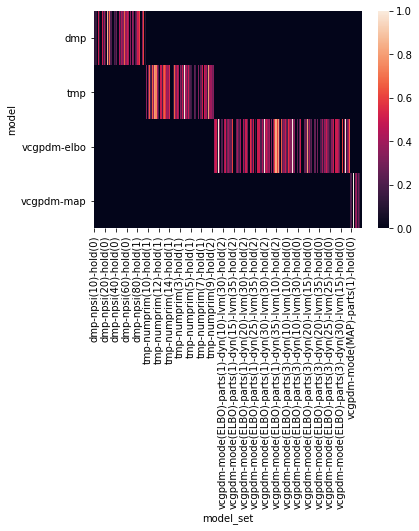

In [58]:
sns.heatmap(model)